In [27]:
# ============================
# ASL DNN vs NLLS COMPARISON
# Supervised NN (Mastropietro-style)
# ============================

import os
import numpy as np
import pydicom
import nibabel as nib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from natsort import natsorted
from tqdm import tqdm

In [28]:
BASE_DIR = "/home/labadmin/Desktop/ashtami/Multipld_project/sctimple/sctdata"

perf_folders = ["perf_1525", "perf_2025", "perf_2525", "perf_3025"]
M0_folders   = ["M0_1525",  "M0_2025",  "M0_2525",  "M0_3025"]
mask_folder  = os.path.join(BASE_DIR, "brain_mask")

OUTPUT_DIR = os.path.join(BASE_DIR, "NN_ASL_Output")
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [29]:
PLDs = np.array([1.525, 2.025, 2.525, 3.025])
tau = 1.8
T1b = 1.65
R1a = 1 / T1b
alpha = 0.85
lmbda = 0.9
eps = 1e-12

In [30]:
def load_dicom_volume(folder):
    files = natsorted([os.path.join(folder, f) for f in os.listdir(folder)])
    slices = [pydicom.dcmread(f) for f in files]
    slices.sort(key=lambda s: int(s.InstanceNumber))
    vol = np.stack([s.pixel_array for s in slices], axis=-1).astype(np.float32)

    px, py = map(float, slices[0].PixelSpacing)
    thk = float(slices[0].SliceThickness)
    affine = np.diag([px, py, thk, 1])
    return vol, affine

In [31]:
def buxton_signal(plds, f, att):
    f_scaled = (2 * alpha * f) / R1a
    s = np.zeros_like(plds)

    for i, t in enumerate(plds):
        if t < att:
            s[i] = 0
        elif t < att + tau:
            s[i] = f_scaled * np.exp(-att * R1a) * (1 - np.exp(-(t - att) * R1a))
        else:
            s[i] = f_scaled * np.exp(-att * R1a) * (1 - np.exp(-tau * R1a)) * \
                   np.exp(-(t - att - tau) * R1a)
    return s

In [32]:
def generate_training_data(N=300_000):
    X, Y = [], []

    for _ in tqdm(range(N), desc="Simulating ASL signals"):
        cbf_ml = np.random.uniform(20, 90)
        att = np.random.uniform(0.5, 3.0)
        f = cbf_ml / (6000 * lmbda)

        sig = buxton_signal(PLDs, f, att)
        sig += np.random.normal(0, 0.02 * np.max(sig), sig.shape)

        X.append(sig)
        Y.append([cbf_ml, att])

    return np.array(X), np.array(Y)

In [33]:
class ASLNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        return self.net(x)

In [34]:
X, Y = generate_training_data()

y_scaler = StandardScaler()
Y_std = y_scaler.fit_transform(Y)

dataset = TensorDataset(torch.tensor(X, dtype=torch.float32),
                        torch.tensor(Y_std, dtype=torch.float32))
loader = DataLoader(dataset, batch_size=512, shuffle=True)

model = ASLNet()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(40):
    total = 0
    for xb, yb in loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        total += loss.item()
    print(f"Epoch {epoch+1}: loss = {total/len(loader):.5f}")

Simulating ASL signals: 100%|████████████████████████████| 300000/300000 [00:03<00:00, 90283.17it/s]


Epoch 1: loss = 0.65654
Epoch 2: loss = 0.53296
Epoch 3: loss = 0.39293
Epoch 4: loss = 0.25549
Epoch 5: loss = 0.20229
Epoch 6: loss = 0.17315
Epoch 7: loss = 0.15495
Epoch 8: loss = 0.13883
Epoch 9: loss = 0.13191
Epoch 10: loss = 0.12393
Epoch 11: loss = 0.11641
Epoch 12: loss = 0.11775
Epoch 13: loss = 0.11176
Epoch 14: loss = 0.11453
Epoch 15: loss = 0.10714
Epoch 16: loss = 0.10762
Epoch 17: loss = 0.10447
Epoch 18: loss = 0.10427
Epoch 19: loss = 0.10021
Epoch 20: loss = 0.10035
Epoch 21: loss = 0.09984
Epoch 22: loss = 0.09661
Epoch 23: loss = 0.09709
Epoch 24: loss = 0.09654
Epoch 25: loss = 0.09804
Epoch 26: loss = 0.09616
Epoch 27: loss = 0.09633
Epoch 28: loss = 0.09268
Epoch 29: loss = 0.09831
Epoch 30: loss = 0.09533
Epoch 31: loss = 0.09330
Epoch 32: loss = 0.09391
Epoch 33: loss = 0.09399
Epoch 34: loss = 0.09295
Epoch 35: loss = 0.09414
Epoch 36: loss = 0.09330
Epoch 37: loss = 0.09273
Epoch 38: loss = 0.09293
Epoch 39: loss = 0.09407
Epoch 40: loss = 0.09230


In [35]:
mask_vol, affine = load_dicom_volume(mask_folder)
mask = mask_vol > 0
sz = mask.shape

deltaM = np.zeros((*sz, 4))
M0 = np.zeros((*sz, 4))

for i in range(4):
    deltaM[..., i], _ = load_dicom_volume(os.path.join(BASE_DIR, perf_folders[i]))
    M0[..., i], _ = load_dicom_volume(os.path.join(BASE_DIR, M0_folders[i]))

In [36]:
print("BASE_DIR =", BASE_DIR)
print("\nContents of BASE_DIR:")
for item in os.listdir(BASE_DIR):
    print(" -", item)

BASE_DIR = /home/labadmin/Desktop/ashtami/Multipld_project/sctimple/sctdata

Contents of BASE_DIR:
 - perf_1525
 - M0_2025
 - perf_3025
 - M0_3025
 - NN_ASL_Output
 - brain_mask_new.m
 - final_out
 - M0_2525
 - perf_2025
 - brain_mask
 - IM47
 - M0_1525
 - perf_2525


In [37]:
CBF = np.full(sz, np.nan)
ATT = np.full(sz, np.nan)

model.eval()
with torch.no_grad():
    for x in tqdm(range(sz[0]), desc="NN inference"):
        for y in range(sz[1]):
            for z in range(sz[2]):
                if not mask[x,y,z]:
                    continue

                dm = deltaM[x,y,z,:] / 100
                m0 = np.mean(M0[x,y,z,:])

                if m0 <= 500:
                    continue

                inp = torch.tensor(dm / (m0 + eps), dtype=torch.float32).unsqueeze(0)
                pred_std = model(inp)
                pred = y_scaler.inverse_transform(pred_std.numpy())

                CBF[x,y,z] = pred[0,0]
                ATT[x,y,z] = pred[0,1]

NN inference: 100%|███████████████████████████████████████████████| 128/128 [00:13<00:00,  9.42it/s]


In [38]:
CBF_nii = nib.Nifti1Image(CBF.astype(np.float32), affine)
ATT_nii = nib.Nifti1Image(ATT.astype(np.float32), affine)

nib.save(CBF_nii, os.path.join(OUTPUT_DIR, "CBF_DNN_ml_100g_min.nii.gz"))
nib.save(ATT_nii, os.path.join(OUTPUT_DIR, "ATT_DNN_sec.nii.gz"))

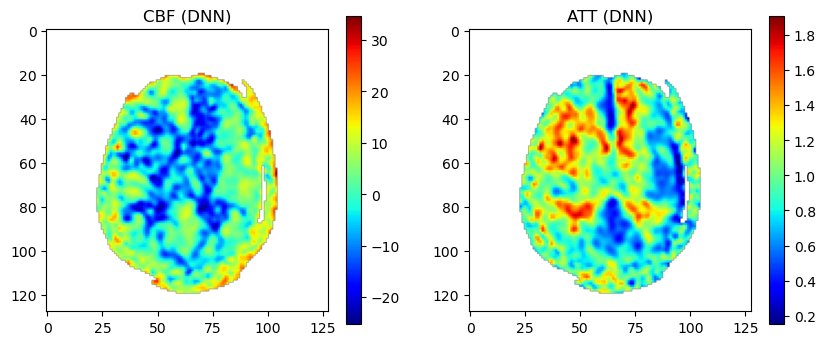

In [39]:
z = sz[2] // 2

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(CBF[:,:,z], cmap="jet")
plt.title("CBF (DNN)")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(ATT[:,:,z], cmap="jet")
plt.title("ATT (DNN)")
plt.colorbar()

plt.show()

In [40]:
# ===============================================================
# PATH UPDATE FOR NEW DIRECTORY
# ===============================================================

# This matches the directory in your screenshot
CURRENT_WORKING_DIR = "/home/labadmin/Desktop/ashtami/Multipld_project/sctimple/nn codes"

# Creating the output folder here
OUTPUT_DIR = os.path.join(CURRENT_WORKING_DIR, "NN_ASL_Output")

# Define the specific case folder
final_output_folder = os.path.join(OUTPUT_DIR, "Case 1 Output")

# Create the folders if they don't exist
os.makedirs(final_output_folder, exist_ok=True)



🧾 Selected slice indices: [5, 19, 10, 15, 19, 30]
----------------------------------------------------
CBF Plotting Range: -16.06 → 21.28 ml/100g/min
ATT Plotting Range: 0.39 → 1.59 s
----------------------------------------------------


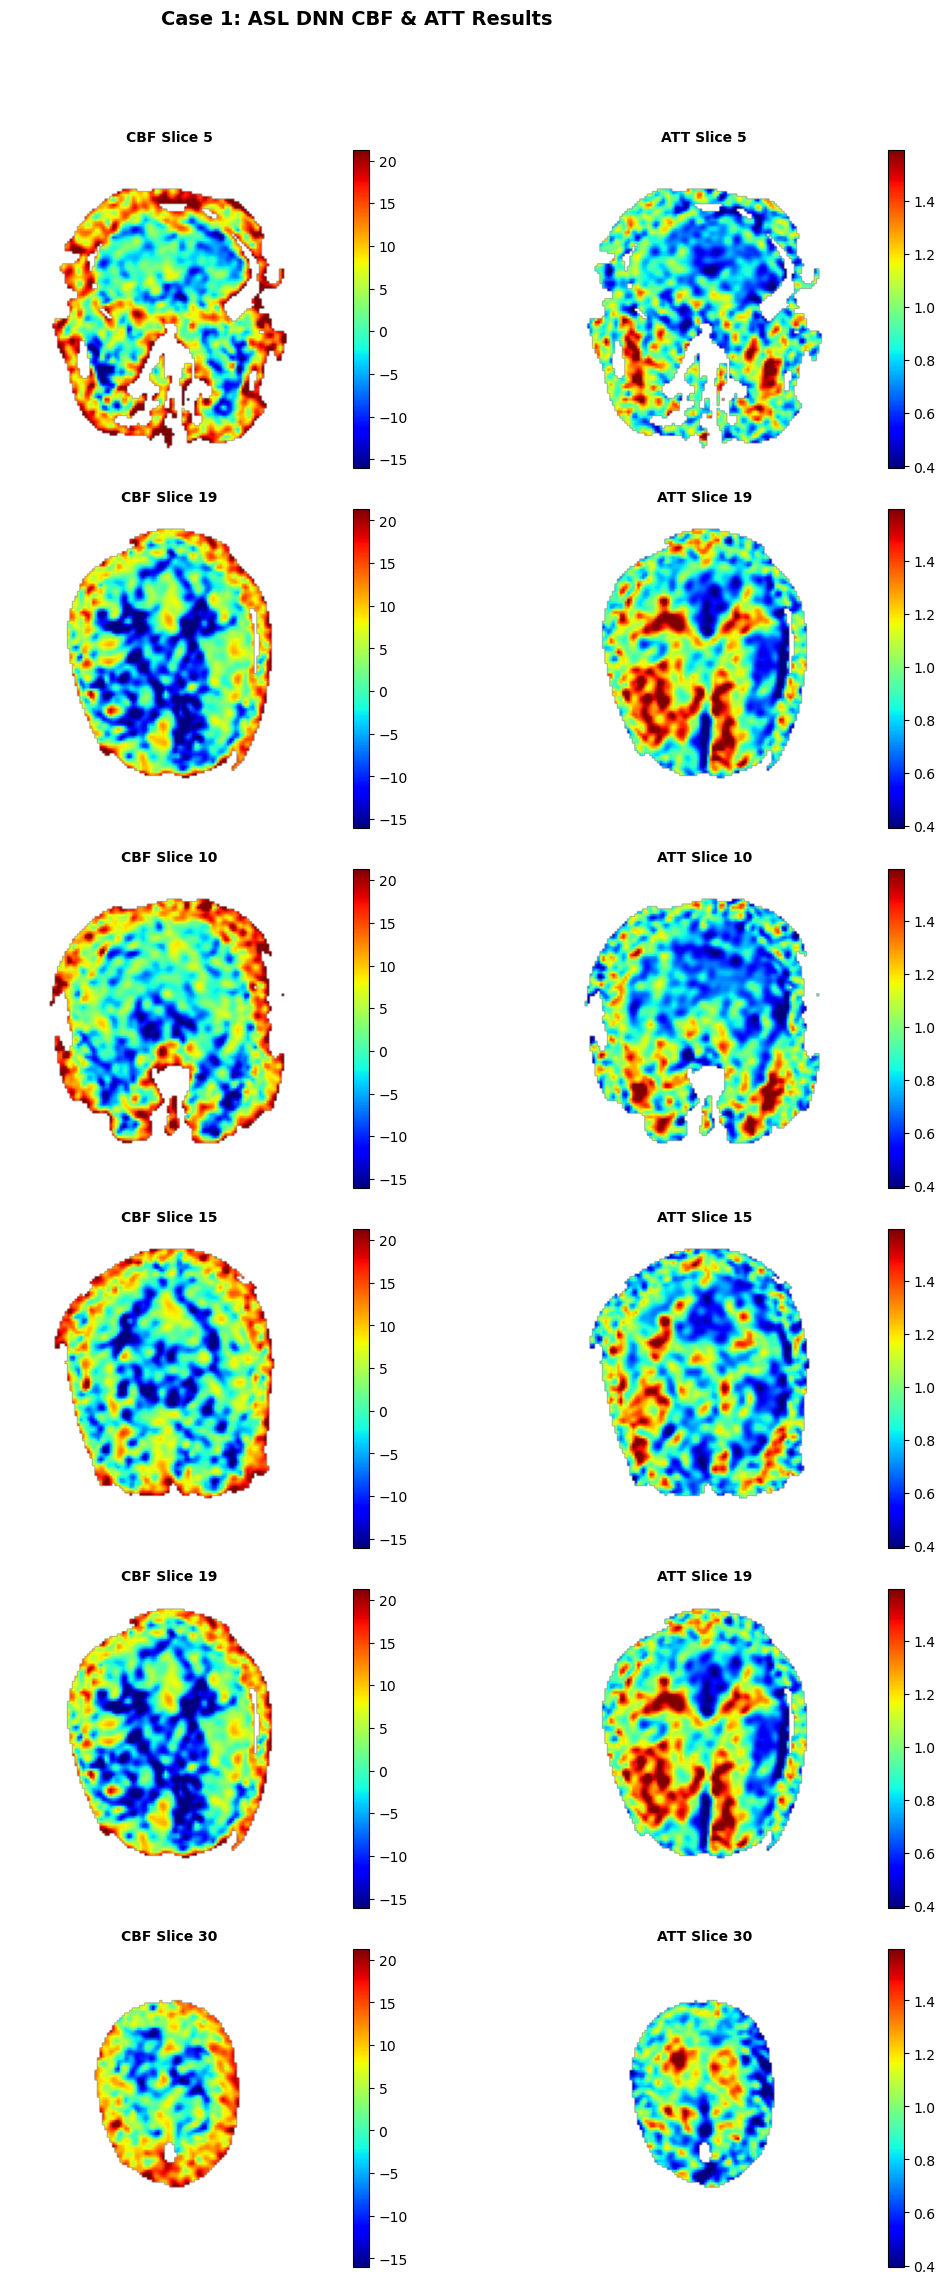


✅ SUCCESS!
📁 Results saved to: /home/labadmin/Desktop/ashtami/Multipld_project/sctimple/nn codes/NN_ASL_Output/Clinical_Export_20260127_233850/Case 1 Output


In [41]:
# ===============================================================
# STEP 7.5 (FULLY UPDATED): Save NN Results as DICOM + PNG 
# ===============================================================
import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
import pydicom

# 1. Map your DNN variables to the naming convention
CBF_map_ml_100g_min = CBF
ATT_map = ATT
output_dir = OUTPUT_DIR 
data_folder = BASE_DIR  

# 2. Choose slices to display (Safely handle volume depth)
slice_indices = [5, sz[2] // 2, 10, 15, 19, 30]
slice_indices = [s for s in slice_indices if s < sz[2]]

print(f"🧾 Selected slice indices: {slice_indices}")

# 3. Create Folder Structure
# We create: OUTPUT_DIR -> Clinical_Export_TS -> Case 1 Output
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
run_folder = os.path.join(output_dir, f"Clinical_Export_{timestamp}")
final_output_folder = os.path.join(run_folder, "Case 1 Output")
os.makedirs(final_output_folder, exist_ok=True)

# 4. Load Reference DICOM
ref_dicom_path = os.path.join(data_folder, "IM47") 
if os.path.exists(ref_dicom_path):
    ref_info = pydicom.dcmread(ref_dicom_path)
    ref_info.PixelRepresentation = 0 # Unsigned integer
    ref_info.BitsAllocated = 16
    ref_info.BitsStored = 16
    ref_info.HighBit = 15
    ref_info.RescaleIntercept = 0
    ref_info.RescaleSlope = 1
else:
    print(f"⚠️ Warning: Reference DICOM {ref_dicom_path} not found. DICOM headers may be incorrect.")
    ref_info = None

# 5. Robust Statistics (Handling NaNs and Outliers)
CBF_min_val = np.nanpercentile(CBF_map_ml_100g_min[mask], 2) if np.any(mask) else 0
CBF_max_val = np.nanpercentile(CBF_map_ml_100g_min[mask], 98) if np.any(mask) else 100
ATT_min_val = np.nanpercentile(ATT_map[mask], 2) if np.any(mask) else 0
ATT_max_val = np.nanpercentile(ATT_map[mask], 98) if np.any(mask) else 2.5

print("----------------------------------------------------")
print(f"CBF Plotting Range: {CBF_min_val:.2f} → {CBF_max_val:.2f} ml/100g/min")
print(f"ATT Plotting Range: {ATT_min_val:.2f} → {ATT_max_val:.2f} s")
print("----------------------------------------------------")

# ---------------------------------------------------------------
# Save each slice as DICOM
# ---------------------------------------------------------------
for z in slice_indices:
    # Extract slices and replace NaNs with 0 immediately to prevent casting errors
    cbf_slice = np.nan_to_num(CBF_map_ml_100g_min[:, :, z])
    att_slice = np.nan_to_num(ATT_map[:, :, z])

    # Scaling to 16-bit (0-65535)
    CBF_scaled = np.clip(((cbf_slice - CBF_min_val) / (CBF_max_val - CBF_min_val + 1e-6) * 65535), 0, 65535).astype(np.uint16)
    ATT_scaled = np.clip(((att_slice - ATT_min_val) / (ATT_max_val - ATT_min_val + 1e-6) * 65535), 0, 65535).astype(np.uint16)

    if ref_info:
        # Save CBF DICOM
        ds_cbf = ref_info.copy()
        ds_cbf.Rows, ds_cbf.Columns = CBF_scaled.shape
        ds_cbf.InstanceNumber = z + 1
        ds_cbf.SeriesDescription = f"Case1_CBF_Slice_{z}"
        ds_cbf.PixelData = CBF_scaled.tobytes()
        pydicom.dcmwrite(os.path.join(final_output_folder, f"CBF_slice_{z:03d}.dcm"), ds_cbf)

        # Save ATT DICOM
        ds_att = ref_info.copy()
        ds_att.Rows, ds_att.Columns = ATT_scaled.shape
        ds_att.InstanceNumber = z + 1
        ds_att.SeriesDescription = f"Case1_ATT_Slice_{z}"
        ds_att.PixelData = ATT_scaled.tobytes()
        pydicom.dcmwrite(os.path.join(final_output_folder, f"ATT_slice_{z:03d}.dcm"), ds_att)

# ---------------------------------------------------------------
# Generate Horizontal Layout PNG
# ---------------------------------------------------------------
plt.figure(figsize=(12, len(slice_indices) * 4))
for i, z in enumerate(slice_indices):
    # Flip for standard radiological viewing
    cbf_disp = np.flipud(CBF_map_ml_100g_min[:, :, z])
    att_disp = np.flipud(ATT_map[:, :, z])

    # --- CBF Column ---
    plt.subplot(len(slice_indices), 2, 2*i + 1)
    im1 = plt.imshow(cbf_disp, cmap="jet", vmin=CBF_min_val, vmax=CBF_max_val)
    plt.title(f"CBF Slice {z}", fontsize=10, weight='bold')
    plt.axis("off")
    plt.colorbar(im1, fraction=0.046, pad=0.04)

    # --- ATT Column ---
    plt.subplot(len(slice_indices), 2, 2*i + 2)
    im2 = plt.imshow(att_disp, cmap="jet", vmin=ATT_min_val, vmax=ATT_max_val)
    plt.title(f"ATT Slice {z}", fontsize=10, weight='bold')
    plt.axis("off")
    plt.colorbar(im2, fraction=0.046, pad=0.04)

plt.suptitle("Case 1: ASL DNN CBF & ATT Results", fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save PNG inside "Case 1 Output"
png_path = os.path.join(final_output_folder, "Case1_Summary_Layout.png")
plt.savefig(png_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ SUCCESS!")
print(f"📁 Results saved to: {final_output_folder}")

In [42]:
igane ahno verende?

Object `verende` not found.
